In [2]:
import os
import joblib
import yaml
import torch
import torch.nn as nn
import zipfile
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

In [7]:
# config file
RAW_DATA_PATH = "../../data/raw/"
PROCESSED_DATA_PATH = "../../data/processed/"

In [8]:
# utils file
with open("../../default_params.yml", "r") as file:
    config = yaml.safe_load(file)

In [9]:
class Loader:
    """
    The Loader class is designed for loading, processing, and preparing image datasets for training machine learning models. It supports operations like unzipping dataset folders, normalizing images, and creating data loaders for batch processing.

    ## Parameters

    | Parameter   | Type   | Description                                             | Default |
    |-------------|--------|---------------------------------------------------------|---------|
    | dataset     | str    | Path to the zip file containing the dataset.            | None    |
    | normalized  | bool   | Indicates whether to normalize images in the dataset.   | True    |

    ## Attributes

    | Attribute        | Type   | Description                                                         |
    |------------------|--------|---------------------------------------------------------------------|
    | batch_size       | int    | The size of data batches. Loaded from `config["dataloader"]`.       |
    | image_height     | int    | The height of images after resizing. Loaded from `config["dataloader"]`. |
    | image_width      | int    | The width of images after resizing. Loaded from `config["dataloader"]`. |
    | p_value          | float  | Probability value for applying certain transformations. Loaded from `config["dataloader"]`. |
    | normalized_value | float  | The mean and std value used for normalization. Loaded from `config["dataloader"]`. |

    ## Methods

    - `unzip_folder()`: Extracts the dataset zip file into a specified raw data path. Raises an exception if the raw data folder does not exist.

    - `_normalized()`: Returns a composition of transformations for normalizing images if normalization is enabled.

    - `create_dataloader()`: Creates a DataLoader for the dataset. Raises exceptions if raw or processed data folders do not exist.

    ## Examples

    ```python
    from config import config  # Ensure you have a config dictionary defined with necessary dataloader configurations.

    # Initialize the Loader with the path to your dataset zip file.
    loader = Loader(dataset="./data.zip", normalized=True)

    # Unzip the dataset.
    loader.unzip_folder()

    # Create the DataLoader for batch processing.
    dataloader = loader.create_dataloader()
    ```
    """
    def __init__(self, dataset=None, normalized=True):
        self.dataset = dataset
        self.normalized = normalized
        self.batch_size = config["dataloader"]["batch_size"]
        self.image_height = config["dataloader"]["image_height"]
        self.image_width = config["dataloader"]["image_width"]
        self.p_value = config["dataloader"]["p"]
        self.normalized_value = config["dataloader"]["normalized"]

    def unzip_folder(self):
        with zipfile.ZipFile(self.dataset, "r") as zip_ref:
            if os.path.exists(RAW_DATA_PATH):
                zip_ref.extractall(RAW_DATA_PATH)
            else:
                raise Exception("Could not find the raw data folder".title())

    def _normalized(self):
        if self.normalized:
            return transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Resize((self.image_height, self.image_width)),
                    transforms.CenterCrop((self.image_height, self.image_width)),
                    transforms.RandomVerticalFlip(p=self.p_value),
                    transforms.Normalize(
                        mean=[
                            self.normalized_value,
                            self.normalized_value,
                            self.normalized_value,
                        ],
                        std=[
                            self.normalized_value,
                            self.normalized_value,
                            self.normalized_value,
                        ],
                    ),
                ]
        )

    def create_dataloader(self):
        if os.path.exists(RAW_DATA_PATH):
            dataset = ImageFolder(root=RAW_DATA_PATH, transform=self._normalized())
            dataloader = DataLoader(
                dataset=dataset, batch_size=self.batch_size, shuffle=True
            )

            if os.path.exists(PROCESSED_DATA_PATH):
                joblib.dump(
                    value=dataloader,
                    filename=os.path.join(PROCESSED_DATA_PATH, "dataloader.pkl"),
                )
            else:
                raise Exception("Could not find the processed data folder".title())

            return dataloader
        else:
            raise Exception("Could not find the raw data folder".title())


if __name__ == "__main__":
    loader = Loader(
        dataset="/Users/shahmuhammadraditrahman/Desktop/data.zip",
        normalized=True,
    )

    loader.unzip_folder()
    dataloader = loader.create_dataloader()

In [10]:
# unittest
import warnings
warnings.filterwarnings("ignore")

sum(data.size(0) for data, _ in dataloader)

2194

In [11]:
# unittest
data, _ = next(iter(dataloader))
data.shape

torch.Size([1, 3, 256, 512])

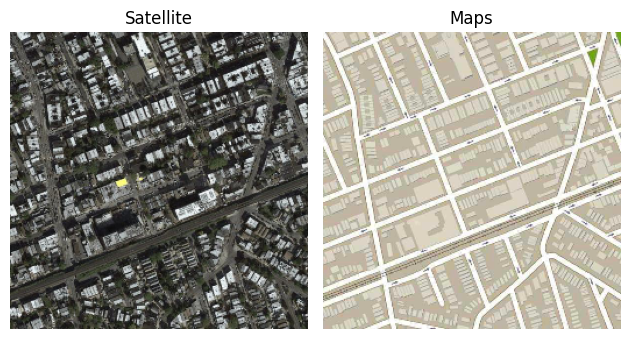

In [13]:
import matplotlib.pyplot as plt

inputs = data[:, :, :, :256]
targets = data[:, :, :, 256:]

inputs = (inputs - inputs.min())/(inputs.max() - inputs.min())
targets = (targets - targets.min())/(targets.max() - targets.min())

plt, axes = plt.subplots(1, 2)

axes[0].imshow(inputs.squeeze().permute(1, 2, 0))
axes[0].set_title("Satellite")
axes[0].set_axis_off()

axes[1].imshow(targets.squeeze().permute(1, 2, 0))
axes[1].set_axis_off()
axes[1].set_title("Maps")

plt.tight_layout()
plt.show()

#### Create the Generator model

In [14]:
import torch
import torch.nn as nn


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder1 = nn.Conv2d(3, 64, 4, 2, 1, bias=False)
        self.encoder2 = nn.Sequential(
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(128),
        )
        self.encoder3 = nn.Sequential(
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(256),
        )
        self.encoder4 = nn.Sequential(
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(512),
        )
        self.encoder5 = nn.Sequential(
            nn.Conv2d(512, 512, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(512),
        )
        self.encoder6 = nn.Sequential(
            nn.Conv2d(512, 512, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(512),
        )
        self.encoder7 = nn.Sequential(
            nn.Conv2d(512, 512, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
        )
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(512, 512, 4, 2, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.Dropout(0.5),
        )
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.Dropout(0.5),
        )
        self.decoder3 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.Dropout(0.5),
        )
        self.decoder4 = nn.Sequential(
            nn.ConvTranspose2d(1024, 256, 4, 2, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
        )
        self.decoder5 = nn.Sequential(
            nn.ConvTranspose2d(512, 128, 4, 2, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
        )
        self.decoder6 = nn.Sequential(
            nn.ConvTranspose2d(256, 64, 4, 2, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
        )
        self.decoder7 = nn.Sequential(
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False), nn.Tanh()
        )

    def forward(self, x):
        encoder1 = self.encoder1(x)
        encoder2 = self.encoder2(encoder1)
        encoder3 = self.encoder3(encoder2)
        encoder4 = self.encoder4(encoder3)
        encoder5 = self.encoder5(encoder4)
        encoder6 = self.encoder6(encoder5)
        latent_space = self.encoder7(encoder6)

        decoder1 = torch.cat((encoder6, self.decoder1(latent_space)), dim=1)
        decoder2 = torch.cat((encoder5, self.decoder2(decoder1)), dim=1)
        decoder3 = torch.cat((encoder4, self.decoder3(decoder2)), dim=1)
        decoder4 = torch.cat((encoder3, self.decoder4(decoder3)), dim=1)
        decoder5 = torch.cat((encoder2, self.decoder5(decoder4)), dim=1)
        decoder6 = torch.cat((encoder1, self.decoder6(decoder5)), dim=1)

        return self.decoder7(decoder6)

In [15]:
# unittest.py
netG = Generator()
data = torch.randn(1, 3, 256, 256)
netG(data).shape

torch.Size([1, 3, 256, 256])

##### Create the Discriminator model

In [16]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(3*2, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(128),
            
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(256),
            
            nn.Conv2d(256, 512, 4, 1, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(512),
            
            nn.Conv2d(512, 1, 4, 1, 1),
            nn.Sigmoid()
        )
        
    def forward(self,x):
        return self.model(x)

In [17]:
# unittest
netD = Discriminator()

image = torch.randn(1, 3, 256, 512)
inputs = image[:, :, :, :256]
targets = image[:, :, :, 256:]

data = torch.cat((inputs, targets), dim=1)

netD(data).shape

torch.Size([1, 1, 30, 30])

#### Create the Generator model in a different way

In [73]:
from collections import OrderedDict

class Encoder(nn.Module):

    def __init__(
        self,
        in_channels=None,
        out_channels=None,
        kernel_size=None,
        stride=None,
        padding=None,
        use_leakyReLU=None,
        use_norm=None,
    ):
        super(Encoder, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.use_leakyReLU = use_leakyReLU
        self.use_norm = use_norm
        self.model = self.encoder_layer()

    def encoder_layer(self):
        layers = OrderedDict()
        layers["encoder"] = nn.Conv2d(
            self.in_channels,
            self.out_channels,
            self.kernel_size,
            self.stride,
            self.padding,
            bias=False,
        )
        if self.use_leakyReLU:
            layers["leakyReLU"] = nn.LeakyReLU(0.2, inplace=True)
        if self.use_norm:
            layers["batch_norm"] = nn.BatchNorm2d(self.out_channels)

        return nn.Sequential(layers)

    def forward(self, x):
        return self.model(x)

In [151]:
from collections import OrderedDict


class Decoder(nn.Module):

    def __init__(
        self,
        in_channels=None,
        out_channels=None,
        kernel_size=None,
        stride=None,
        padding=None,
        use_leakyReLU=None,
        use_norm=None,
    ):
        super(Decoder, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.use_leakyReLU = use_leakyReLU
        self.use_norm = use_norm
        self.model = self.encoder_layer()

    def encoder_layer(self):
        layers = OrderedDict()
        layers["decoder"] = nn.ConvTranspose2d(
            self.in_channels,
            self.out_channels,
            self.kernel_size,
            self.stride,
            self.padding,
            bias=False,
        )
        if self.use_leakyReLU:
            layers["ReLU"] = nn.ReLU(inplace=True)
        if self.use_norm:
            layers["batch_norm"] = nn.BatchNorm2d(self.out_channels)

        return nn.Sequential(layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((skip_input, x), 1)
        return x

In [167]:
class G(nn.Module):
    def __init__(self):
        super(G, self).__init__()
        self.net1 = Encoder(3, 64, 4, 2, 1, 0.2, False)
        self.net2 = Encoder(64, 128, 4, 2, 1, 0.2, True)
        self.net3 = Encoder(128, 256, 4, 2, 1, 0.2, True)
        self.net4 = Encoder(256, 512, 4, 2, 1, 0.2, True)
        self.net5 = Encoder(512, 512, 4, 2, 1, 0.2, True)
        self.net6 = Encoder(512, 512, 4, 2, 1, 0.2, True)
        self.net7 = Encoder(512, 512, 4, 2, 1, 0.2, False)

        self.de1 = Decoder(512, 512, 4, 2, 1, True, True)
        self.de2 = Decoder(1024, 512, 4, 2, 1, True, True)
        self.de3 = Decoder(1024, 512, 4, 2, 1, True, True)
        self.de4 = Decoder(1024, 256, 4, 2, 1, True, True)
        self.de5 = Decoder(512, 128, 4, 2, 1, True, True)
        self.de6 = Decoder(256, 64, 4, 2, 1, True, True)
        # self.de7 = Decoder(128, 3, 4, 2, 1, False, False)

        self.out = nn.ConvTranspose2d(64 * 2, 3, 4, 2, 1, bias=False)

    def forward(self, x):
        x1 = self.net1(x)
        x2 = self.net2(x1)
        x3 = self.net3(x2)
        x4 = self.net4(x3)
        x5 = self.net5(x4)
        x6 = self.net6(x5)
        out = self.net7(x6)

        x = self.de1(out, x6)
        x = self.de2(x, x5)
        x = self.de3(x, x4)
        x = self.de4(x, x3)
        x = self.de5(x, x2)
        x = self.de6(x, x1)
        out = self.out(x)

        return torch.sigmoid(out)

In [170]:
g = G()

g(torch.randn(1, 3, 256, 256)).shape

torch.Size([1, 3, 256, 256])

In [18]:
#unittest
sum(params.numel() for params in g.parameters())

#### Define the optimizer, loss and device

In [21]:
import torch.optim as optim

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

optimizerG = optim.Adam(netG.to(device).parameters(), lr = 0.0002, betas = (0.5, 0.999))
optimizerD = optim.Adam(netD.to(device).parameters(), lr = 0.0002, betas=(0.5, 0.999))

criterion = nn.BCELoss()